## Training the Single Atom Diffusion Scaling Law in Python

Author: Yifan Wang [(wangyf@udel.edu)](wangyf@udel.edu)

The scaling law correlates the diffusion activation energy for support single atoms on the support with physcial descriptors

The form of the scaling law is obtained from various supervised machine learning methods and the traing procedure is shown below. The ML methods used include:

- LASSO regression

- Ridge regression

- Elastic net

- Genetic Programming (GP) based on sybomlic regression

- Ordinary Least Square (OLS) regression

The primary physical descriptors (features) include 

- Ec (cohesive energy of the metal)  

- Ebind (the binding energy of the single atom)

The secondary descriptors are the polynomial terms (orders from -2 to 2) of the primary descriptors  

In [0]:
#%% Import all libraries 

import os
import pickle
import numpy as np
import pandas as pd
from scipy.stats import norm

import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
 

from sklearn import linear_model
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import (ElasticNet, ElasticNetCV, Lasso, LassoCV,
                                  Ridge, RidgeCV, enet_path, lasso_path)
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import (LeaveOneOut, RepeatedKFold,
                                     cross_val_score, train_test_split)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# import customized plotting functions
import regression_tools as rtools

# Set plotting format
font = {'size'   : 20}

matplotlib.rc('font', **font)
matplotlib.rcParams['axes.linewidth'] = 1.5
matplotlib.rcParams['xtick.major.size'] = 12
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['xtick.major.width'] = 3
matplotlib.rcParams['ytick.major.size'] = 12
matplotlib.rcParams['ytick.major.width'] = 3
matplotlib.rcParams['legend.fontsize'] = 16
matplotlib.rcParams['figure.dpi'] = 300. # set plotting resolution



### Step 1 - Import Data 

In [0]:
#%% Import adsorption data from a csv file

data = pd.read_csv('Ea_data.csv', header = 0)

metal = np.array(data['metal'])
support = np.array(data['support'])
Ec = np.array(data['Ec']) # cohesive energy of the metal
Ebind = np.array(data['Ebind']) #binding energy of the single atom
Ea = np.array(data['Ea']) # Diffusion barrier of the single atom onto the support

### Step 2 - Generate the descriptors (features)

In [0]:
#%% Prepare for the descriptors (features) 

# Numerical orders
orders = [1, -1, 0.5, -0.5, 2, -2]


def transformers(xv, orders):

    '''
    Transform each column of primary featurs into secondary features
    '''
    x_features = np.reshape(xv, (len(xv),1))
    
    for oi in orders[1:]:
        x_features = np.concatenate((x_features, np.reshape(xv, (len(xv),1))**oi), axis = 1)
    
    '''
    Add additional features
    '''
    x_features = np.concatenate((x_features, np.log(np.reshape(xv, (len(xv),1)))), axis = 1)
    
    return x_features
'''
Get the names and orders
'''    
# primary and secondary feature names
x_primary_feature_names = ['Ec', 'Ebind']
x_secondary_feature_names_2d = []
orders_log = orders + ['ln']

# The number for all numerical opeators 
all_orders_log = []

for xi in x_primary_feature_names:  
    x_secondary_feature_names_2d.append([xi + '_' + str(oi) for oi in orders_log])
    all_orders_log += orders_log
    
x_secondary_feature_names = []
for xi in x_secondary_feature_names_2d:
    x_secondary_feature_names += xi


'''
Apply to the data
''' 
Ec_features = transformers(Ec, orders)    
Ebind_features = transformers(Ebind, orders)   


X_init = np.concatenate((Ec_features, Ebind_features),axis = 1) 


poly = PolynomialFeatures(2, interaction_only=True)
X_poly = poly.fit_transform(X_init)
orders_m = poly.powers_

'''
Select nonzero features
'''
x_features_poly = ['1'] # nonzero feature names in a 2d list
poly_indices_nonrepeat = [0] # indices in the polynominal order matrix 
# Create feature names for plotting in Latex
x_plot_feature_names = ['b'] + x_secondary_feature_names
x_plot_feature_names = ['1', r'$\rm E_c$', r'$\rm E_c^{-1}$', r'$\rm E_c^{0.5}$', r'$\rm E_c^{-0.5}$',  r'$\rm E_c^2$', r'$\rm E_c^{-2}$', r'$\rm ln(E_c)$', r'$\rm E_{bind}$', r'$\rm E_{bind}^{-1}$', r'$\rm E_{bind}^{0.5}$', r'$\rm E_{bind}^{-0.5}$', r'$\rm E_{bind}^2$', r'$\rm E_{bind}^{-2}$', r'$\rm ln(E_{bind})$']

n_features = len(x_plot_feature_names)


'''
Get the indices and feature names for nonzero features, 
namely with nonzero order
'''
for pi, powers in enumerate(poly.powers_):
    
    powers_nonzero = (powers > 0).nonzero()[0]
    
    if not list(powers_nonzero) == []:
        
        features_nonzero = [x_secondary_feature_names[pi] for pi in powers_nonzero]
        orders_nonzero = np.array([all_orders_log[pi] for pi in powers_nonzero])
    
        try: 
            # making sure the zero sum is from one feature each
            ordersum = orders_nonzero.sum()
            f1_order = powers_nonzero[0] in range(0, len(x_secondary_feature_names_2d[0]))
            f2_order = powers_nonzero[1] in range(len(x_secondary_feature_names_2d[0]), len(x_secondary_feature_names_2d[0])+len(x_secondary_feature_names_2d[1]))
        
            if ordersum == 0:
                if (f1_order and f2_order):
                    x_features_poly.append(features_nonzero)
                    poly_indices_nonrepeat.append(pi)
       
            else:
                    x_features_poly.append(features_nonzero)
                    poly_indices_nonrepeat.append(pi)
       
        except:
            
            x_features_poly.append(features_nonzero)
            poly_indices_nonrepeat.append(pi)

poly_indices_nonrepeat = np.array(poly_indices_nonrepeat)


x_features_poly_combined = []
for fi in x_features_poly:
    if len(fi) > 1:
        fi_combined = []
        for fj in fi:
            fi_combined += fj
            fi_combined = ''.join(fi_combined)

        x_features_poly_combined.append(fi_combined)
    else: x_features_poly_combined.append(fi[0])


'''
Additional Screening, take out repeated features (this is done manually)
'''
repeated_indices = [16, 18, 27, 29, 40, 49, 83, 85, 87, 89, 93, 95]
poly_indices_nonrepeat = [poly_indices_nonrepeat[i] for i in range(0, len(poly_indices_nonrepeat)) if i not in repeated_indices]
x_features_poly_combined = [x_features_poly_combined[i] for i in range(0, len(x_features_poly_combined)) if i not in repeated_indices]
x_features_poly = [x_features_poly[i] for i in range(0, len(x_features_poly)) if i not in repeated_indices]



### Step 3 - Scaling the features to zero mean and unit variance


In [0]:
#%%Process X and y, scale

X_before_scaling = X_poly[:,poly_indices_nonrepeat]
y = Ea
scaler = StandardScaler().fit(X_before_scaling[:,1:])

sv = scaler.scale_
mv = scaler.mean_

X = X_before_scaling.copy()
X[:,1:] = scaler.transform(X_before_scaling[:,1:])
fit_int_flag = False # Not fitting for intercept, as the first coefficient is the intercept


### Step 4 - Set the cross-validation scheme


In [11]:
#%% Cross validation setting

# Set random state here
random_state = 0
# Train test split, save 10% of data point to the test set
X_train, X_test, y_train, y_test, X_before_train, X_before_test = train_test_split(X, y, X_before_scaling, test_size=0.2, random_state = random_state)
                    
                    
# The alpha grid used for plotting path
alphas_grid = np.logspace(0, -3, 20)

# Cross-validation scheme                                  
rkf = RepeatedKFold(n_splits = 10, n_repeats = 10 , random_state =random_state)

# Explicitly take out the train/test set
X_cv_train, y_cv_train, X_cv_test, y_cv_test = [],[],[],[]

for train_index, test_index in rkf.split(X_train):
    X_cv_train.append(X_train[train_index])
    y_cv_train.append(y_train[train_index])
    X_cv_test.append(X_train[test_index])
    y_cv_test.append(y_train[test_index])
    

### Step 5 - Train ML models


#### LASSO Regression

No handles with labels found to put in legend.


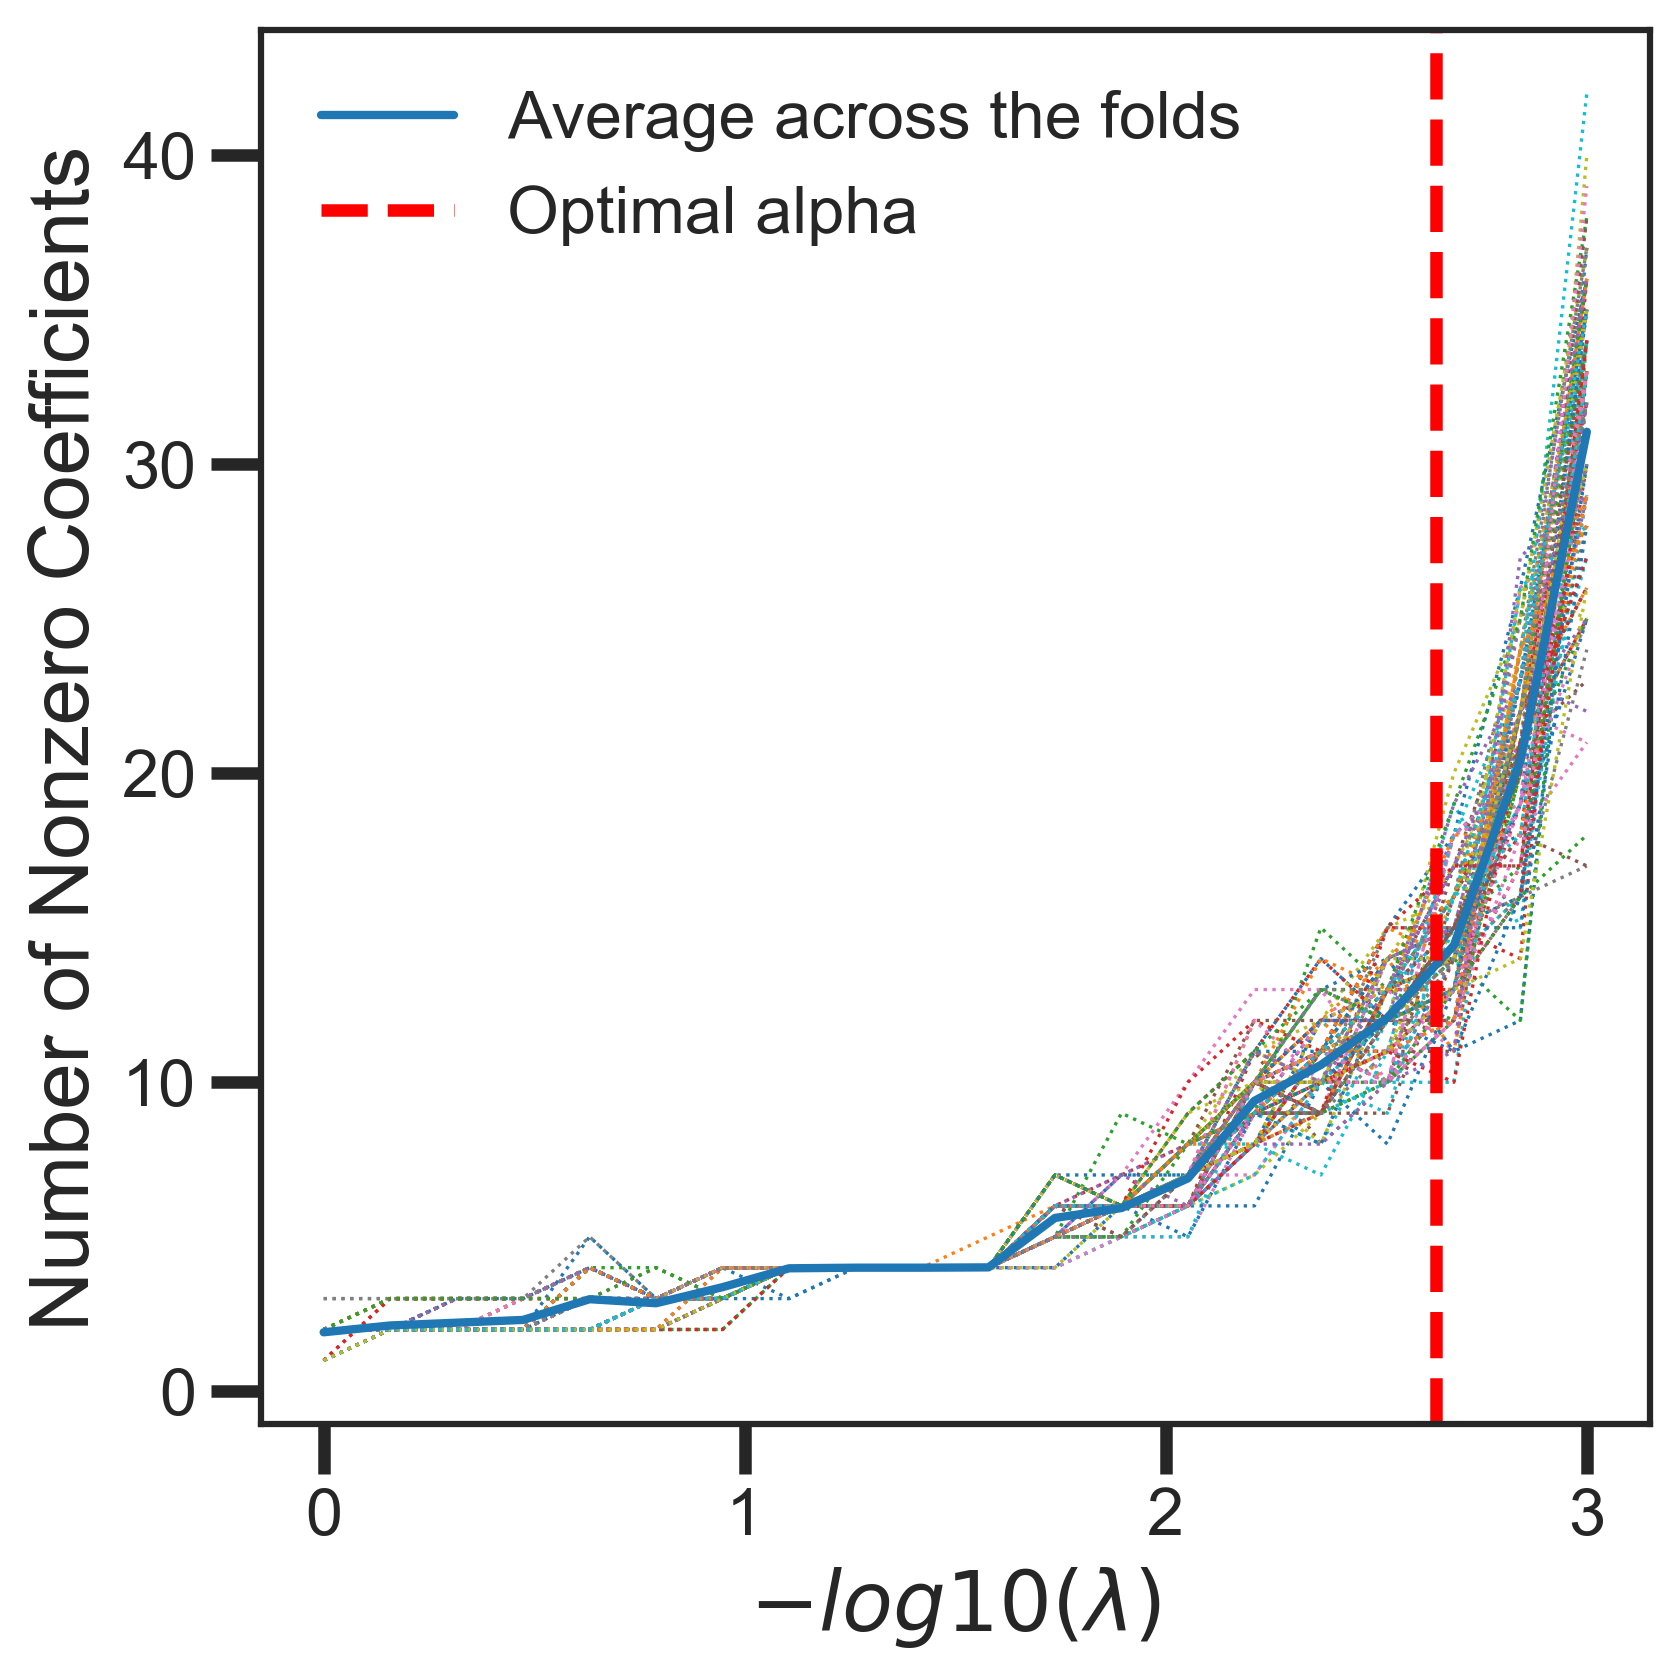

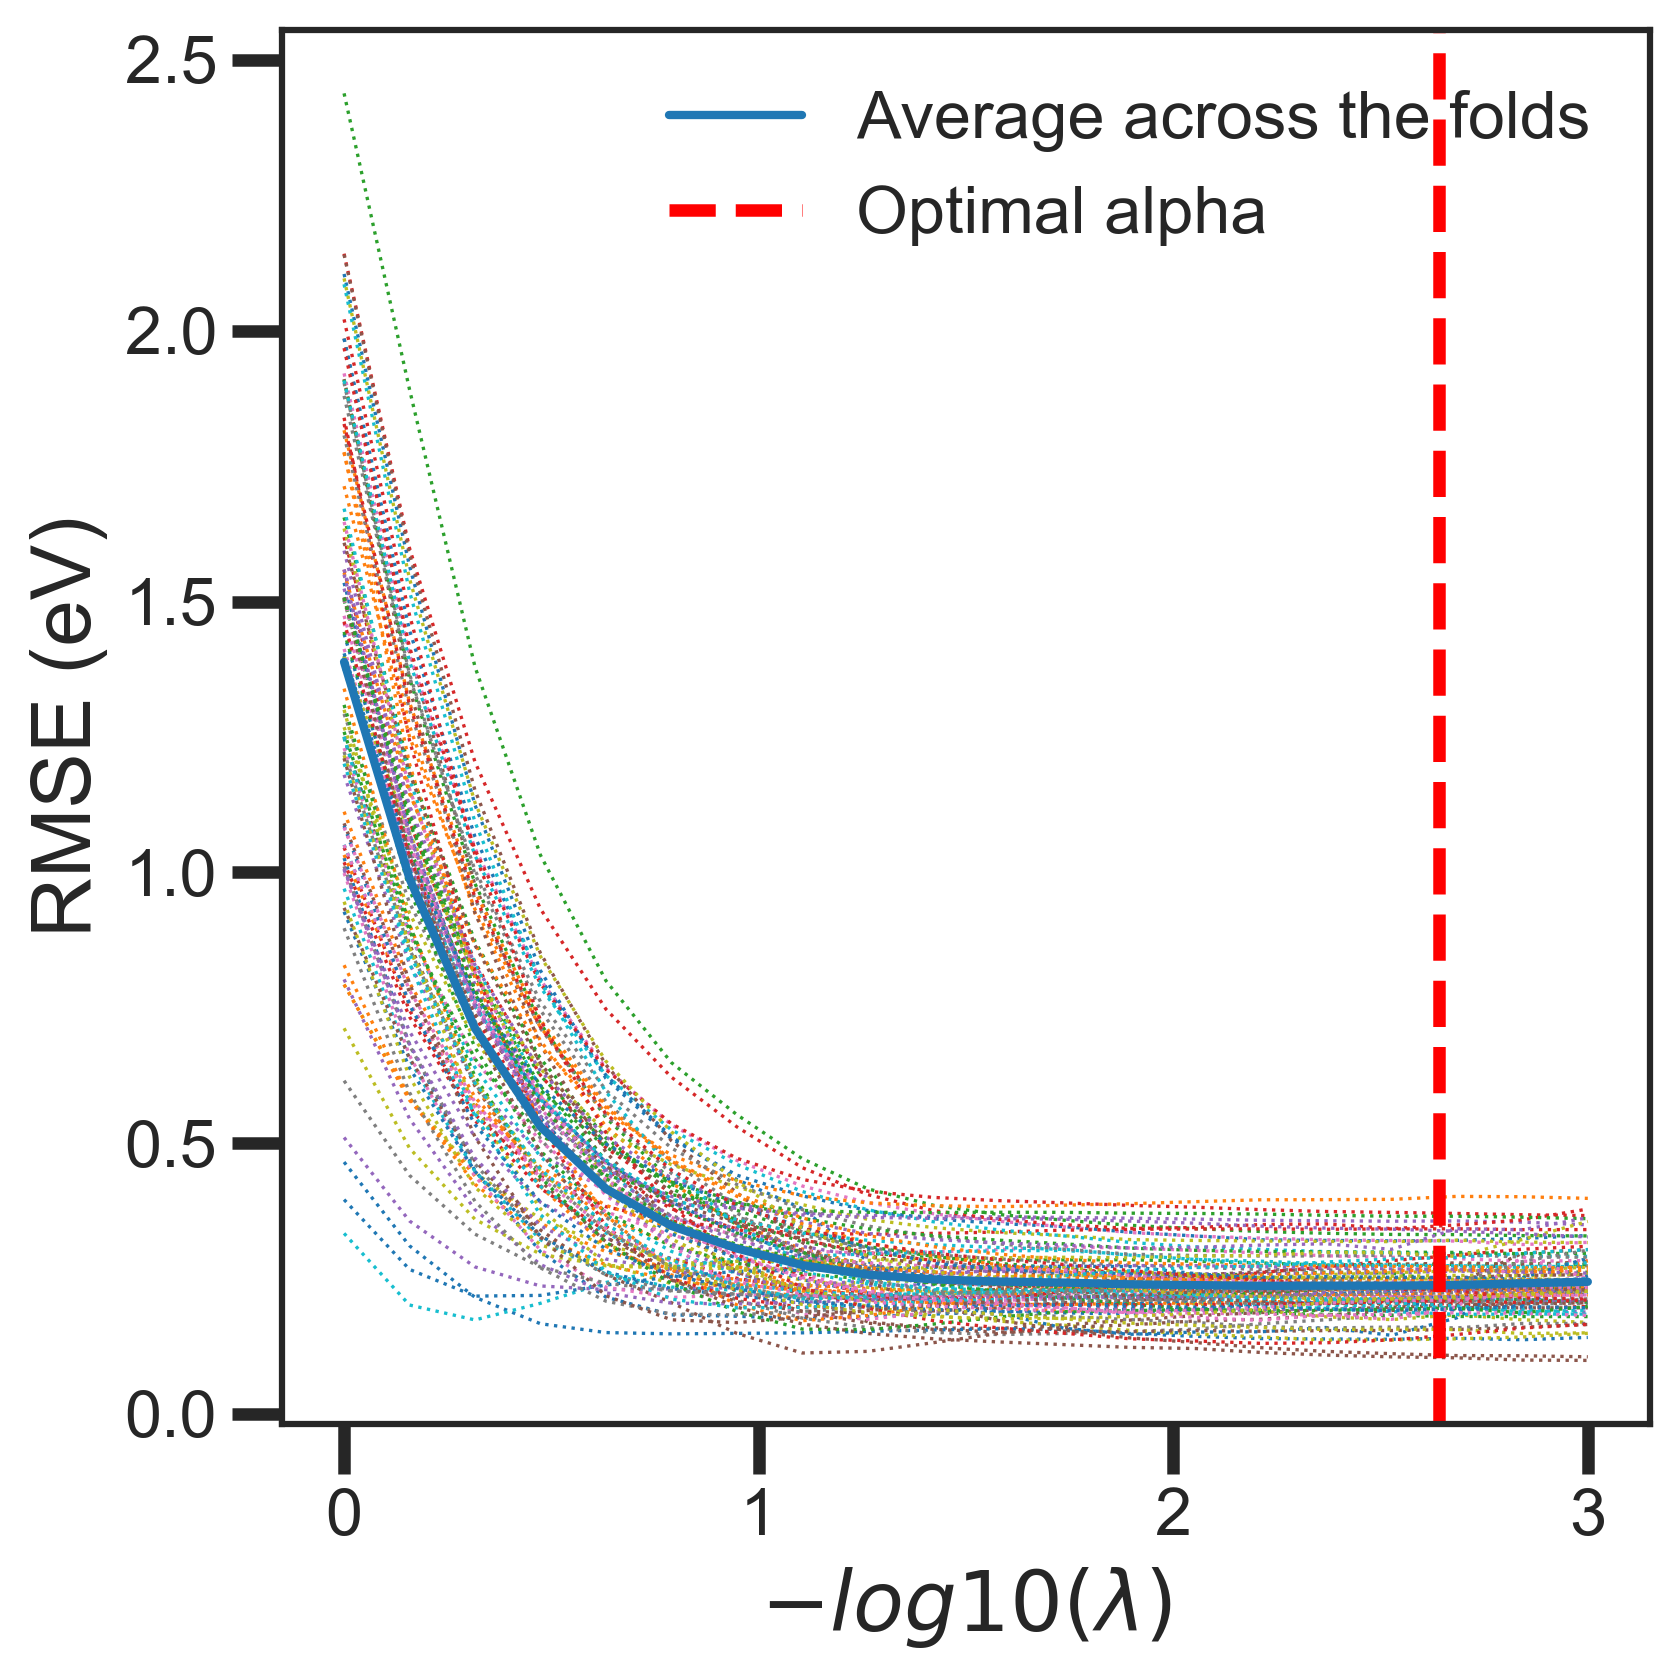

<Figure size 1800x1800 with 0 Axes>

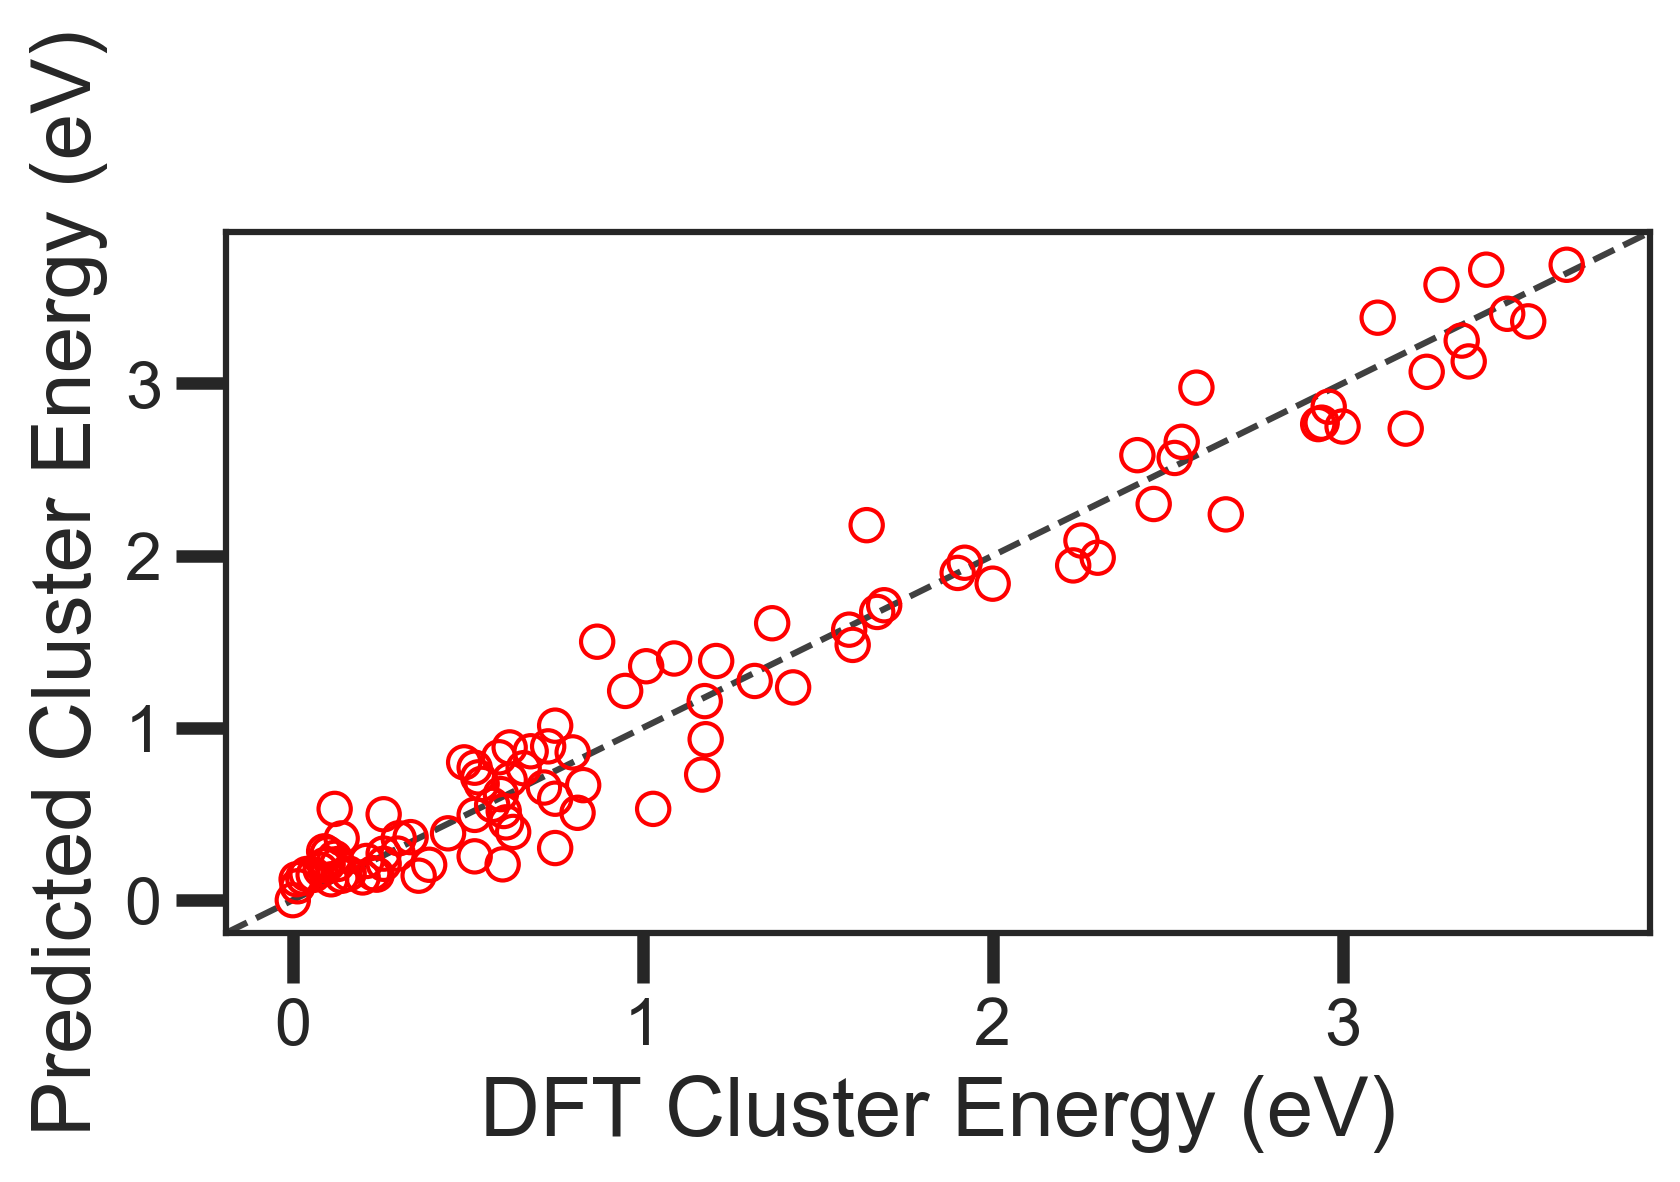

<Figure size 1800x1800 with 0 Axes>

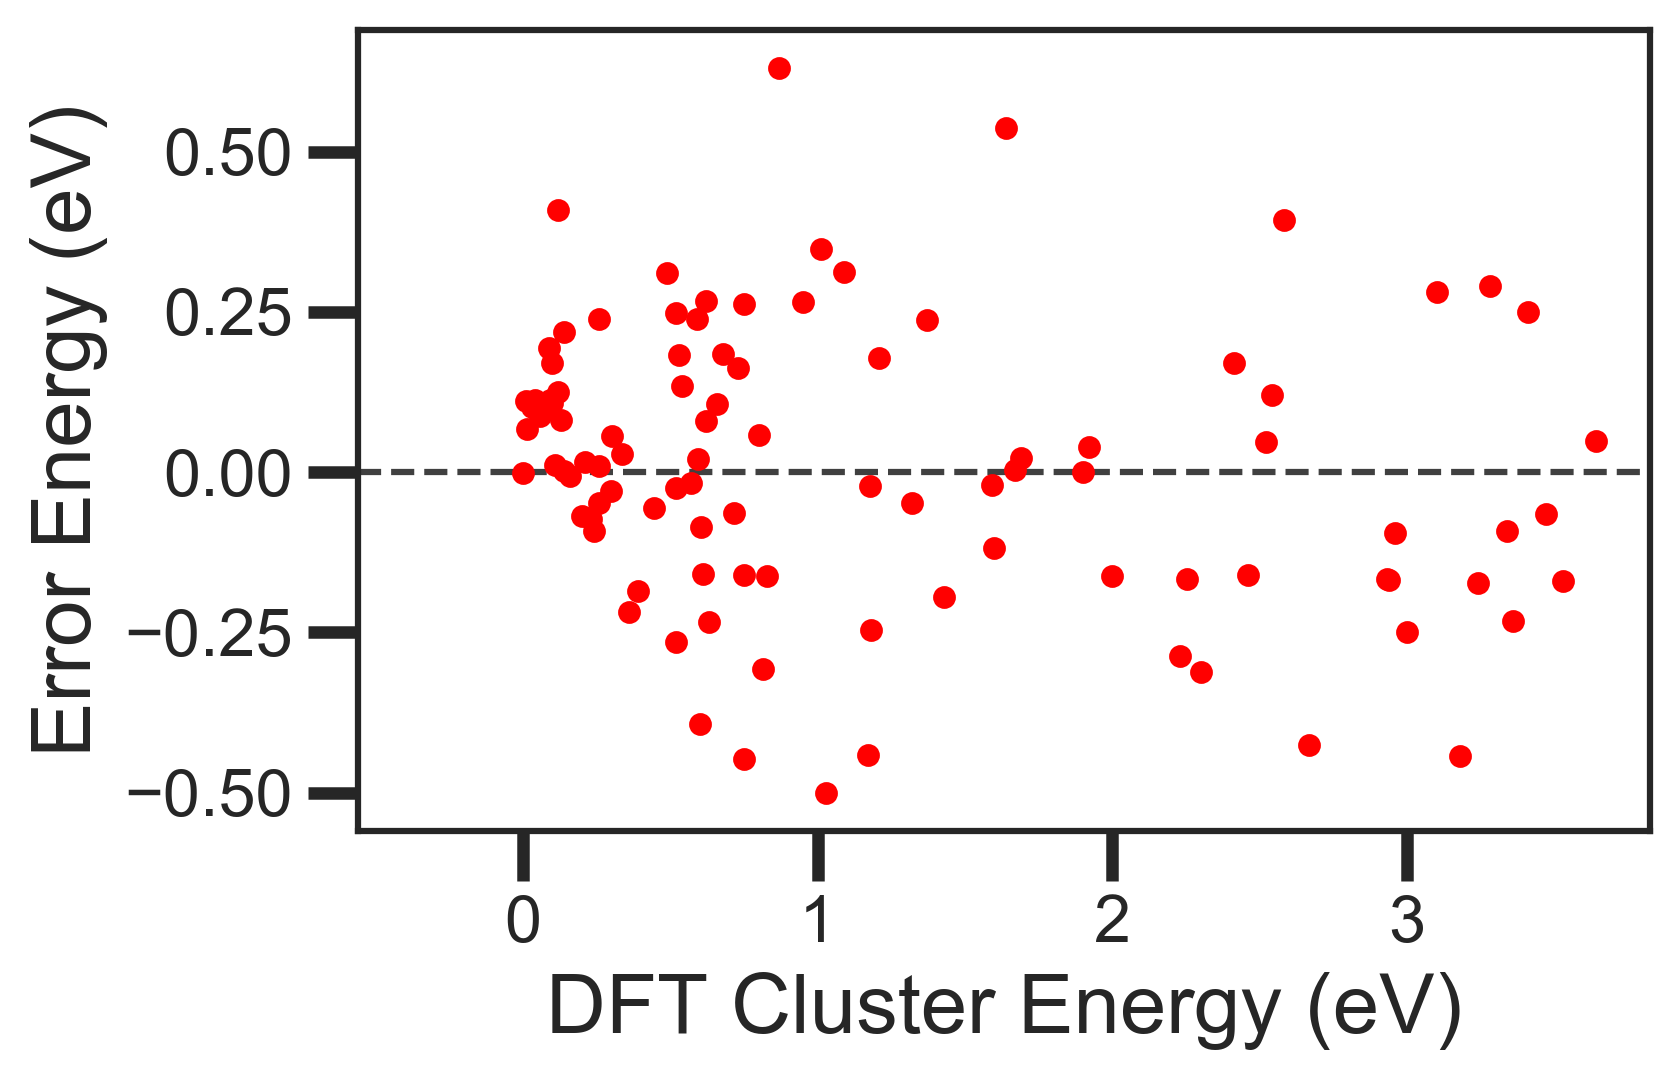

<Figure size 1800x1800 with 0 Axes>

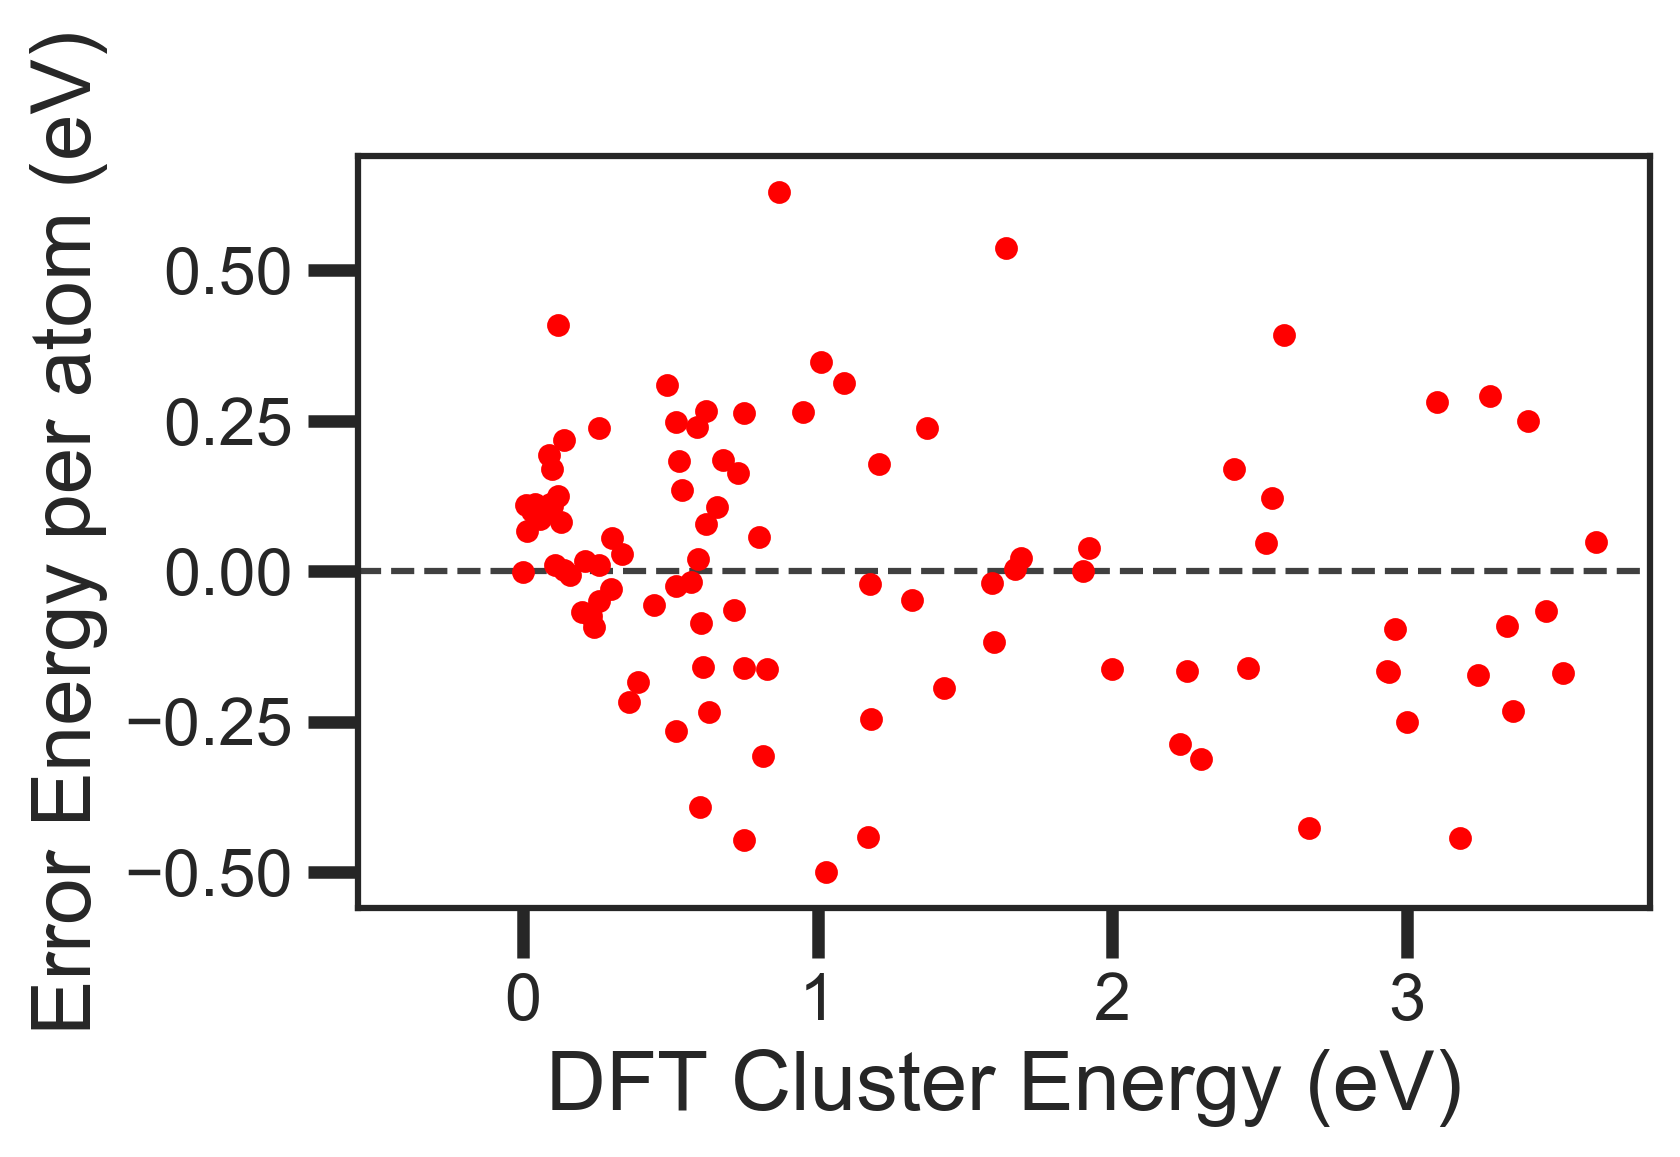

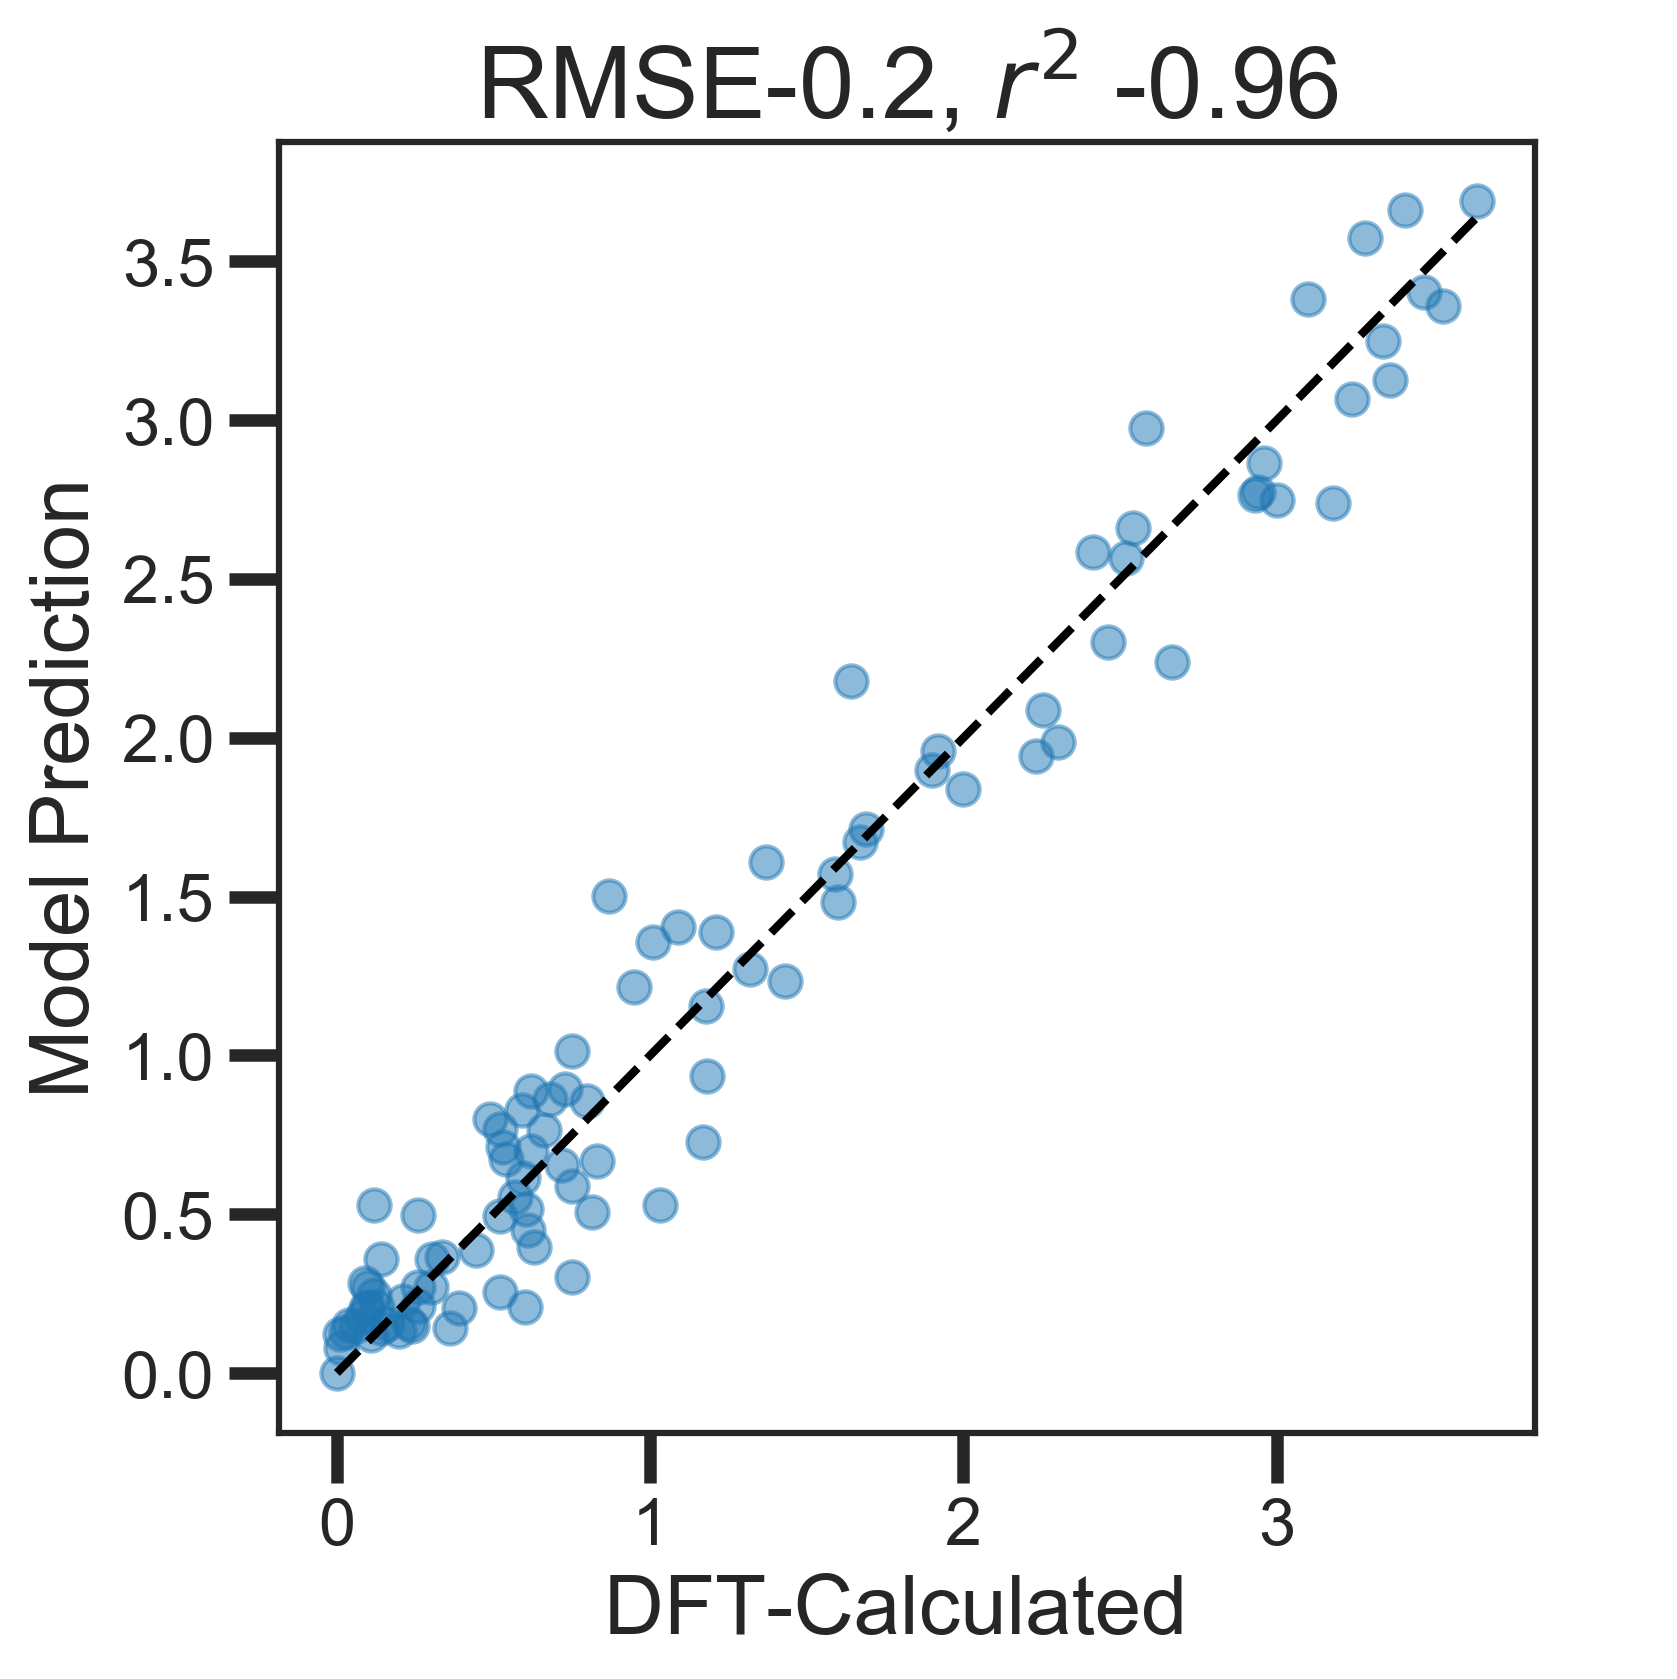

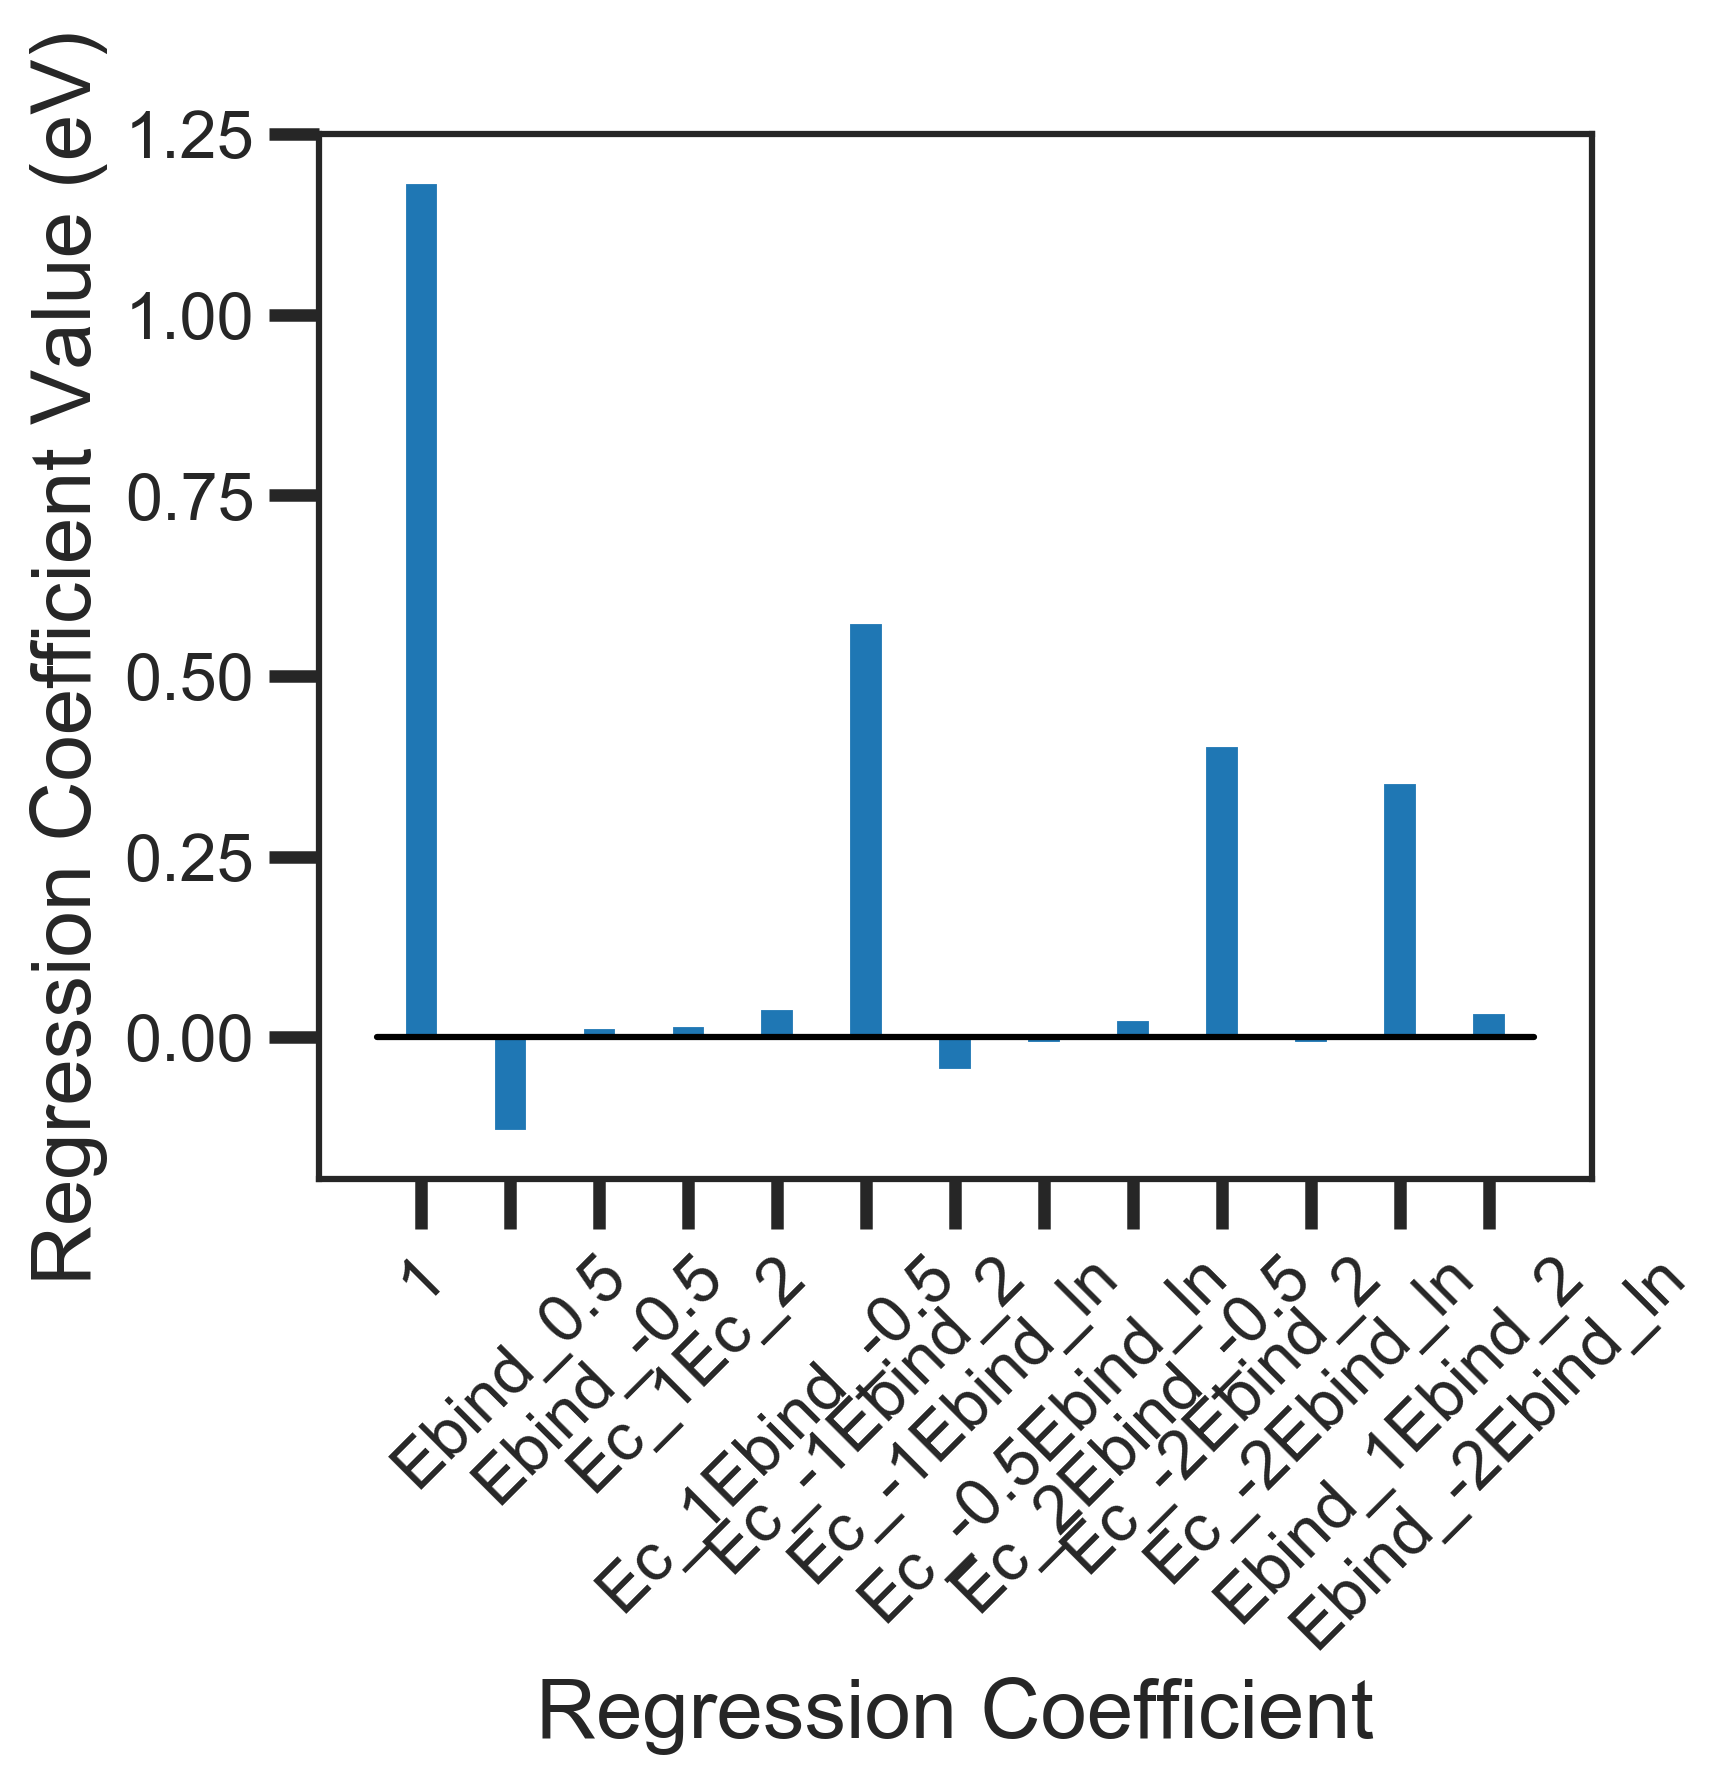

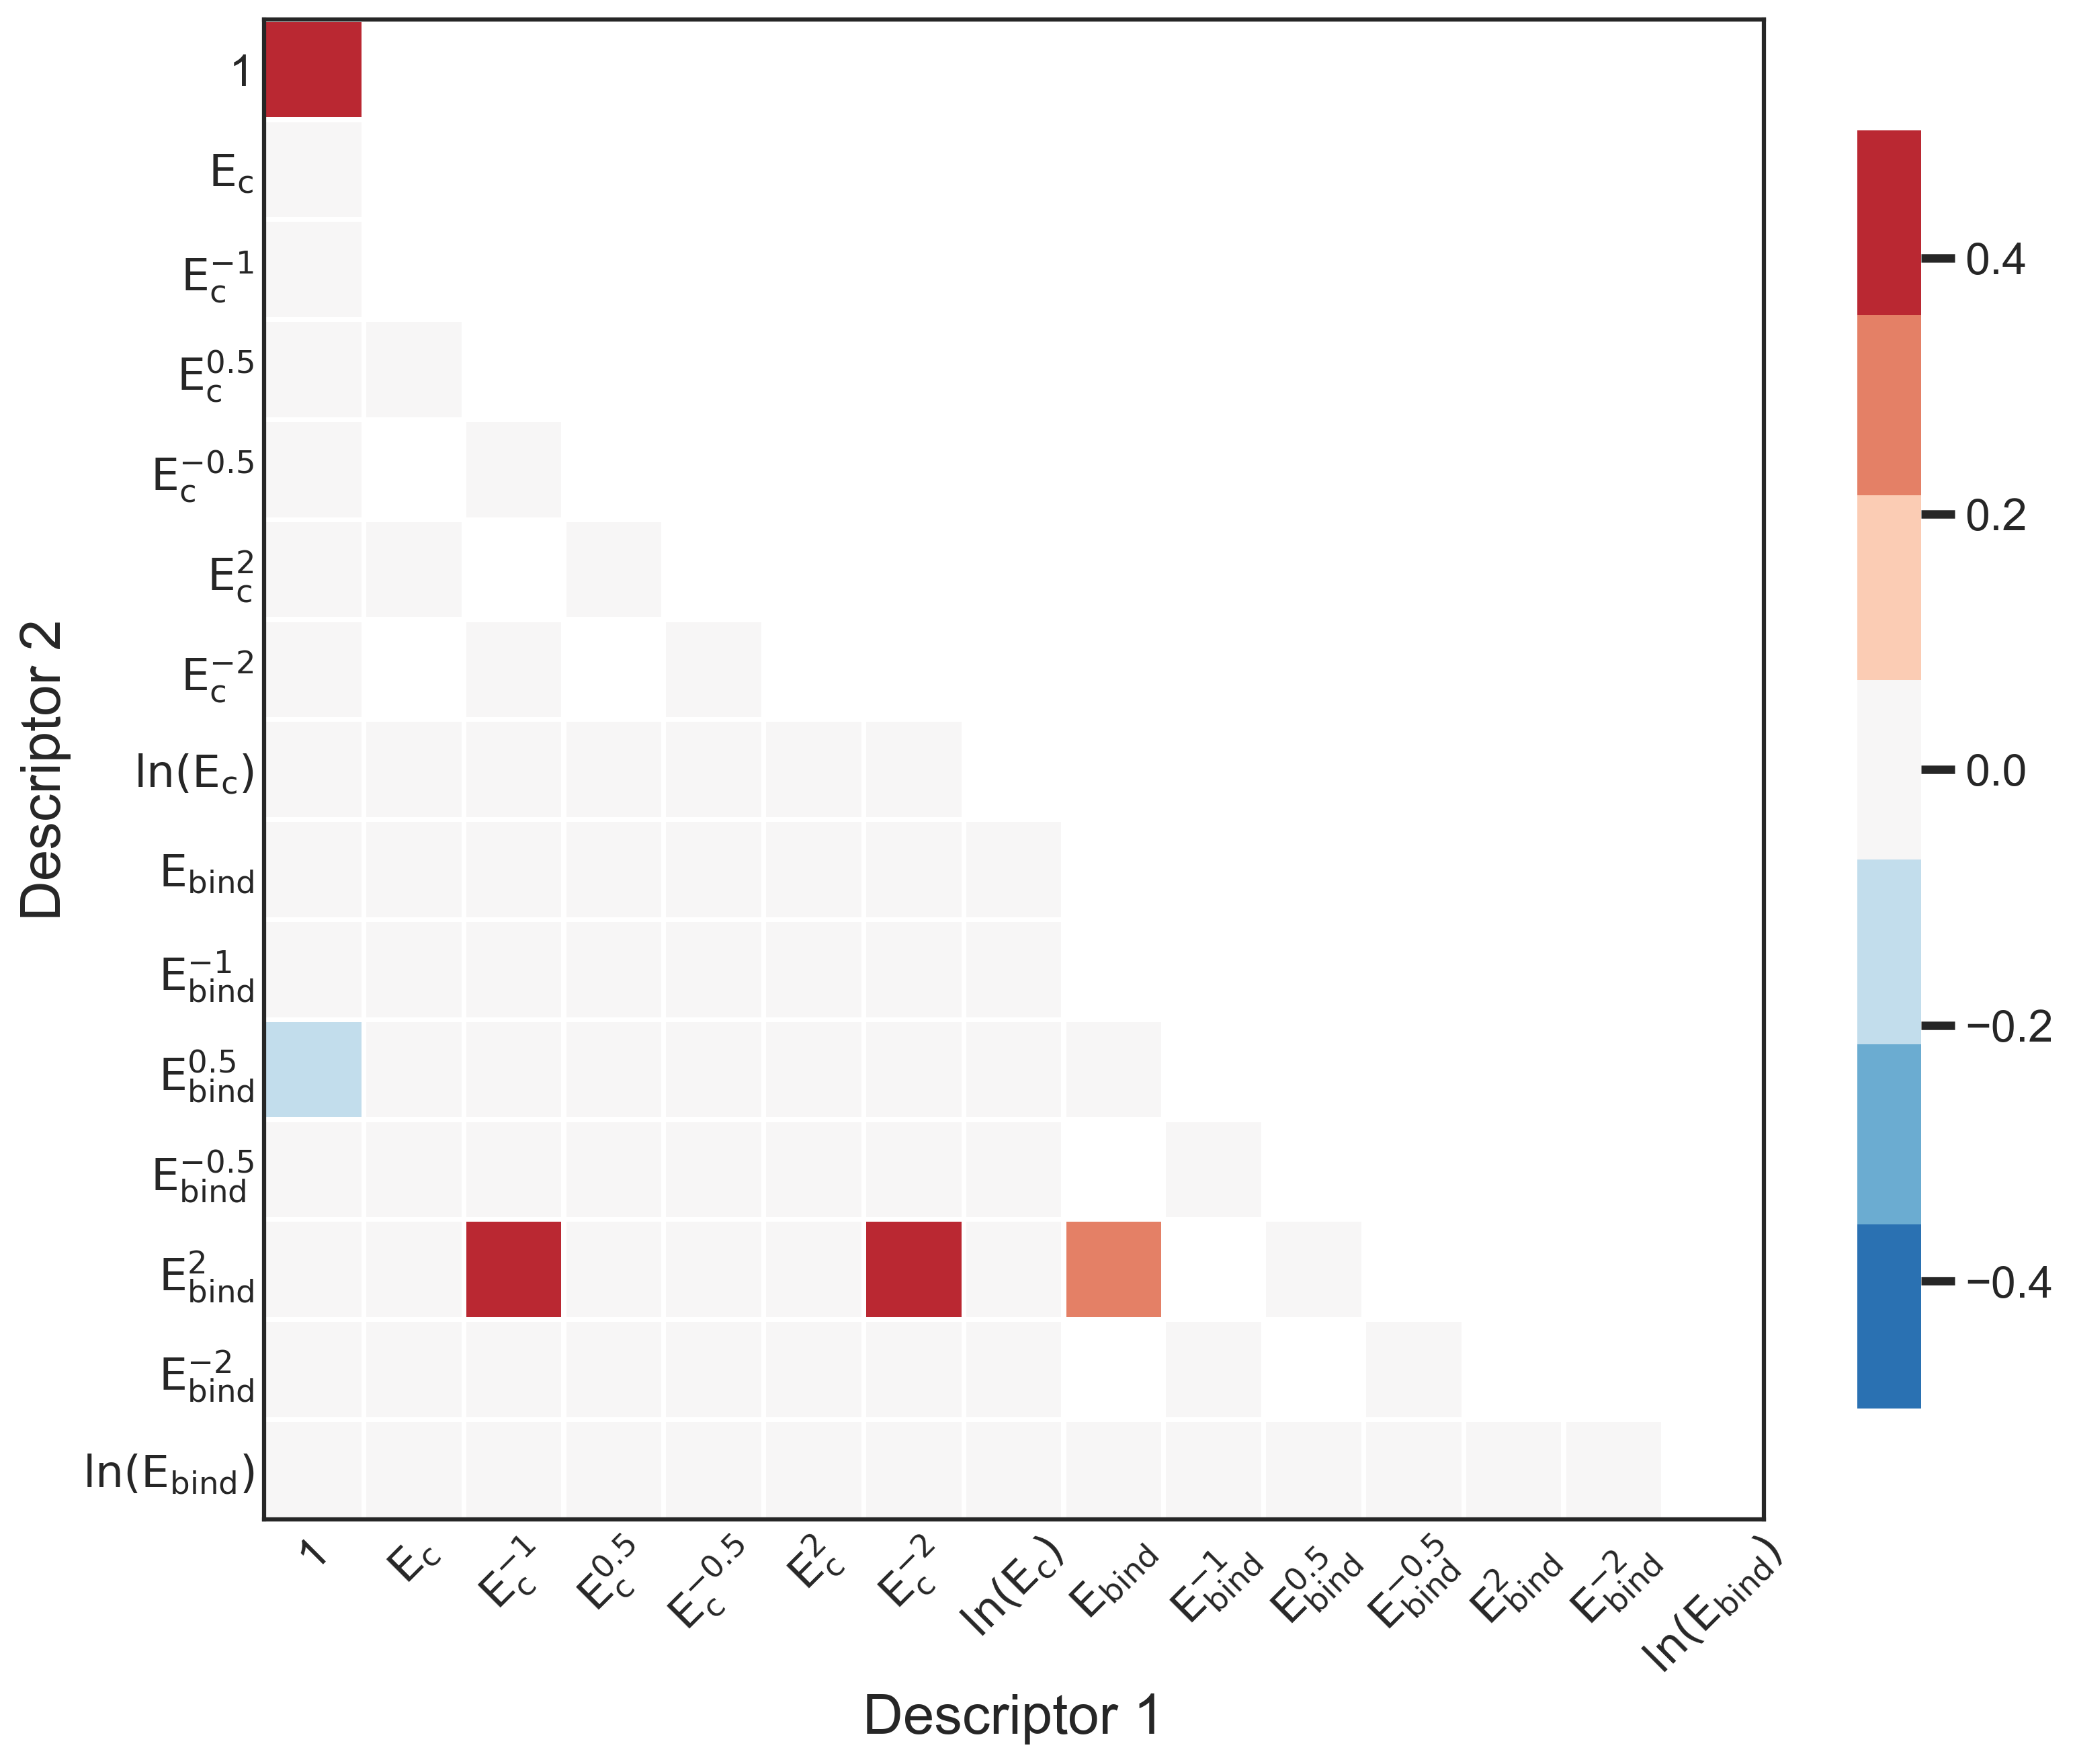

In [12]:
#%% LASSO regression
'''   
# LassoCV to obtain the best alpha, the proper training of Lasso
'''
model_name = 'lasso'
base_dir = os.getcwd()
output_dir = os.path.join(base_dir, model_name)
if not os.path.exists(output_dir): os.makedirs(output_dir)    

lasso_cv  = LassoCV(cv = rkf,  max_iter = 1e7, tol = 0.001, fit_intercept=fit_int_flag, random_state=random_state)
lasso_cv.fit(X_train, y_train)

# the optimal alpha from lassocv
lasso_alpha = lasso_cv.alpha_
# Coefficients for each term
lasso_coefs = lasso_cv.coef_
# The original intercepts 
lasso_intercept = lasso_cv.intercept_

# Access the errors 
y_predict_test = lasso_cv.predict(X_test)
y_predict_train = lasso_cv.predict(X_train)


lasso_RMSE_test = np.sqrt(mean_squared_error(y_test, y_predict_test))
lasso_RMSE_train = np.sqrt(mean_squared_error(y_train, y_predict_train))
lasso_r2_train = r2_score(y_train, y_predict_train)


##Use alpha grid prepare for lassopath
lasso_RMSE_path, lasso_coef_path = rtools.cal_path(alphas_grid, Lasso, X_cv_train, y_cv_train, X_cv_test, y_cv_test, fit_int_flag)
##lasso_path to get alphas and coef_path, somehow individual CV does not work
#lasso_alphas, lasso_coef_path, _ = lasso_path(X_train, y_train, alphas = alphas_grid, fit_intercept=fit_int_flag)
rtools.plot_path(X, y, lasso_alpha, alphas_grid, lasso_RMSE_path, lasso_coef_path, lasso_cv, model_name, output_dir)
lasso_RMSE, lasso_r2 = rtools.parity_plot(y, lasso_cv.predict(X), model_name, output_dir, lasso_RMSE_test)
lasso_prediction = lasso_cv.predict(X)

# The indices for non-zero coefficients/significant cluster interactions 
J_index = np.nonzero(lasso_coefs)[0]
# The number of non-zero coefficients/significant cluster interactions  
n_nonzero = len(J_index)
# The values of non-zero coefficients/significant cluster interactions  
J_nonzero = lasso_coefs[J_index] 

# collect nonzero freature names
x_feature_nonzero_combined = [x_features_poly_combined[pi] for pi in J_index]
x_feature_nonzero = [x_features_poly[pi] for pi in J_index]
rtools.plot_coef(J_nonzero, model_name, output_dir, x_feature_nonzero_combined)

'''
Convert the coefficient to unnormalized form
'''
lasso_coefs_unnormailized = np.zeros_like(lasso_coefs)
lasso_coefs_unnormailized[1:] = lasso_coefs[1:]/sv
lasso_coefs_unnormailized[0] = lasso_coefs[0] - np.sum(mv/sv*lasso_coefs[1:])


# Implement the plot functions on lasso
lasso_coef_matrix = rtools.make_coef_matrix(x_feature_nonzero, J_nonzero, n_features, x_secondary_feature_names)
rtools.plot_tri_correlation_matrix(lasso_coef_matrix, output_dir, x_plot_feature_names, model_name)
